**import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Bidirectional, GlobalMaxPooling1D, Flatten

In [2]:
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### **Read Dataset**

In [60]:
!gdown --id 1kt7tyva7GytaaG-Rgbf-1bb2ZchHQe_f

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kt7tyva7GytaaG-Rgbf-1bb2ZchHQe_f
To: /content/review_20_clothing_product.csv
100% 16.0M/16.0M [00:00<00:00, 163MB/s]


In [61]:
df = pd.read_csv('/content/review_20_clothing_product.csv')

In [62]:
df.head()

,Unnamed: 0,stars,title,body
0,0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...
1,1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...
2,2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...
3,3,5.0 out of 5 stars,OMG I love these pants.,They feel so good and smooth. Great if you are...
4,4,4.0 out of 5 stars,"Nice, but large","These are comfortable, but as others have ment..."


In [63]:
df.shape

(84474, 4)

**Prepare Dataset**

In [64]:
df['star'] = df['stars'].apply(lambda x: str(x).split()[0]).astype(float)

In [65]:
df.head(3)

,Unnamed: 0,stars,title,body,star
0,0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0
1,1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0
2,2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0


In [66]:
df.shape

(84474, 5)

In [67]:
#remove 3 stars reviews
indexAge = df[(df['star'] == 3)].index
df.drop(indexAge, inplace=True)

In [68]:
df.shape

(77483, 5)

In [69]:
df['sentiment'] = df['star'].apply(lambda x: 1 if x >= 3 else 0)

In [70]:
df.head(3)

,Unnamed: 0,stars,title,body,star,sentiment
0,0,4.0 out of 5 stars,Short people and big booty Judy’s.,Honest review would be more like a 4.5. Issue ...,4.0,1
1,1,4.0 out of 5 stars,Great Pants,I LOVE these pants! I originally bought 2x bec...,4.0,1
2,2,5.0 out of 5 stars,Kinda big,I usually wear a medium however this was close...,5.0,1


In [71]:
df['sentiment'].unique()

array([1, 0])

In [72]:
df['sentiment'].value_counts()

1    64680
0    12803
Name: sentiment, dtype: int64

In [73]:
positive = df[(df['sentiment'] == 1)]
negative = df[(df['sentiment'] == 0)]

In [74]:
print(positive.shape)
print(negative.shape)

(64680, 6)
(12803, 6)


In [75]:
#positive_sample = positive.sample(n=13000, replace=True, random_state=50)
positive_sample = positive.sample(n=64680, replace=True, random_state=50)

In [76]:
print(positive_sample.shape)
print(negative.shape)

(64680, 6)
(12803, 6)


In [77]:
data = pd.concat([positive_sample, negative], axis=0)

In [78]:
data.shape

(77483, 6)

In [79]:
data.tail()

,Unnamed: 0,stars,title,body,star,sentiment
84410,34608,NaN,Kaufempfehlung,Wegen der verschiedenen Rezensionen war ich hi...,NaN,0
84411,34609,NaN,Banging!,Bang on,NaN,0
84412,34610,NaN,Four Stars,"Very good delivery time. As expected,I always ...",NaN,0
84413,34611,NaN,War sehr günstig,Super schön und bequem,NaN,0
84470,34668,2.0 out of 5 stars,Only lasted 2 months before toe seam came apart,Only lasted 2 months before toe seam came apart,2.0,0


### **Preprocessing**

In [80]:
bodies = data['body'].values
titles = data['title'].values
y = data['sentiment'].values

In [81]:
sentences = [(str(t)+' '+str(b)) for t,b in zip(titles,bodies)]

In [82]:
sentences[0]

'Love this shirt I love this shirt. Size was perfect!'

In [83]:
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenize = [tokenizer.tokenize(s.lower()) for s in sentences]

In [84]:
sentences_tokenize[0]

['love',
 'this',
 'shirt',
 'i',
 'love',
 'this',
 'shirt',
 'size',
 'was',
 'perfect']

In [85]:
stop_words = set(stopwords.words("english"))

In [86]:
len(stop_words)

179

In [87]:
sentences_tokenize_filtered = [[w for w in sentence if w not in stop_words] for sentence in sentences_tokenize]

In [88]:
sentences_tokenize_filtered[0]

['love', 'shirt', 'love', 'shirt', 'size', 'perfect']

In [89]:
lem = WordNetLemmatizer()
sentences_tokenize_filtered_stem = [[lem.lemmatize(w) for w in sentence] for sentence in sentences_tokenize_filtered]

In [90]:
sentences_tokenize_filtered_stem[0]

['love', 'shirt', 'love', 'shirt', 'size', 'perfect']

In [91]:
corpus = []
for sentence in sentences_tokenize_filtered:
  s = ''
  s = ' '.join(sentence)
  corpus.append(s) 

In [92]:
corpus[0:6]

['love shirt love shirt size perfect',
 'fit perfect fit good looks cute',
 'buen producto el tamaño es el adecuado muy buena calidad',
 'perfection comfy long excellent coverage',
 'exactly advertised gift fits expected',
 'satisfied classic']

**keras Tokenizer**

In [93]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [94]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [95]:
vocab_size = len(tokenizer.word_index) + 1

In [96]:
vocab_size

30127

In [97]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [98]:
data_to_sequences = tokenizer.texts_to_sequences(corpus)

In [99]:
maxlen = max_length(data_to_sequences)
maxlen

536

In [100]:
data_to_sequences[0]

[4, 28, 4, 28, 5, 7]

In [101]:
pad_data_to_sequences = pad_sequences(data_to_sequences, maxlen=100)

In [102]:
pad_data_to_sequences[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 28,  4, 28,  5,  7],
      dtype=int32)

In [103]:
print(pad_data_to_sequences.shape)
print(y.shape)

(77483, 100)
(77483,)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(pad_data_to_sequences, y, test_size=0.3, shuffle=True, random_state=50)

In [105]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(54238, 100)
(23245, 100)
(54238,)
(23245,)


## **Neural Networks**

### **CNN Model**

In [106]:
i = Input(shape=(100,))
x = Embedding(vocab_size, 50, input_length=100)(i)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [107]:
model = Model(i, x)

In [108]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 50)           1506350   
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           8032      
                                                                 
 dropout_1 (Dropout)         (None, 100, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            5152      
                                                           

In [110]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=256)

Epoch 1/7
212/212 [==============================] - 8s 11ms/step - loss: 0.3142 - accuracy: 0.8819 - val_loss: 0.2198 - val_accuracy: 0.9268
Epoch 2/7
212/212 [==============================] - 2s 8ms/step - loss: 0.1813 - accuracy: 0.9350 - val_loss: 0.2207 - val_accuracy: 0.9322
Epoch 3/7
212/212 [==============================] - 2s 8ms/step - loss: 0.1440 - accuracy: 0.9491 - val_loss: 0.2046 - val_accuracy: 0.9280
Epoch 4/7
212/212 [==============================] - 2s 8ms/step - loss: 0.1182 - accuracy: 0.9585 - val_loss: 0.1893 - val_accuracy: 0.9320
Epoch 5/7
212/212 [==============================] - 2s 8ms/step - loss: 0.0966 - accuracy: 0.9663 - val_loss: 0.2067 - val_accuracy: 0.9325
Epoch 6/7
212/212 [==============================] - 2s 8ms/step - loss: 0.0818 - accuracy: 0.9723 - val_loss: 0.2228 - val_accuracy: 0.9306
Epoch 7/7
212/212 [==============================] - 2s 8ms/step - loss: 0.0734 - accuracy: 0.9755 - val_loss: 0.2328 - val_accuracy: 0.9303


In [111]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

727/727 [==============================] - 2s 3ms/step - loss: 0.2328 - accuracy: 0.9303
Accuracy: 93.03%


In [112]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = [(1 if y >= 0.5 else 0) for y in y_pred]
y_pred = np.array(y_pred)

727/727 [==============================] - 1s 2ms/step


In [113]:
print(classification_report(y_true, y_pred, target_names=['Negative Reviews','Positive Reviews']))

                  precision    recall  f1-score   support

Negative Reviews       0.82      0.72      0.77      3753
Positive Reviews       0.95      0.97      0.96     19492

        accuracy                           0.93     23245
       macro avg       0.89      0.85      0.86     23245
    weighted avg       0.93      0.93      0.93     23245



### **LSTM Model**

In [114]:
i = Input(shape=(100,))
x = Embedding(vocab_size, 50, input_length=100)(i)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [115]:
model = Model(i, x)

In [116]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [117]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 50)           1506350   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         183296    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                82176     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                           

In [118]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=256)

Epoch 1/7
212/212 [==============================] - 13s 43ms/step - loss: 0.2810 - accuracy: 0.8965 - val_loss: 0.1964 - val_accuracy: 0.9257
Epoch 2/7
212/212 [==============================] - 7s 34ms/step - loss: 0.1765 - accuracy: 0.9367 - val_loss: 0.1870 - val_accuracy: 0.9318
Epoch 3/7
212/212 [==============================] - 7s 34ms/step - loss: 0.1484 - accuracy: 0.9477 - val_loss: 0.1927 - val_accuracy: 0.9300
Epoch 4/7
212/212 [==============================] - 7s 34ms/step - loss: 0.1295 - accuracy: 0.9553 - val_loss: 0.2036 - val_accuracy: 0.9272
Epoch 5/7
212/212 [==============================] - 7s 34ms/step - loss: 0.1156 - accuracy: 0.9603 - val_loss: 0.2291 - val_accuracy: 0.9283
Epoch 6/7
212/212 [==============================] - 7s 34ms/step - loss: 0.1037 - accuracy: 0.9642 - val_loss: 0.2366 - val_accuracy: 0.9322
Epoch 7/7
212/212 [==============================] - 7s 34ms/step - loss: 0.0942 - accuracy: 0.9678 - val_loss: 0.2371 - val_accuracy: 0.9290


In [119]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

727/727 [==============================] - 6s 8ms/step - loss: 0.2371 - accuracy: 0.9290
Accuracy: 92.90%


In [120]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = [(1 if y >= 0.5 else 0) for y in y_pred]
y_pred = np.array(y_pred)

727/727 [==============================] - 7s 8ms/step


In [121]:
print(classification_report(y_true, y_pred, target_names=['Negative Reviews','Positive Reviews']))

                  precision    recall  f1-score   support

Negative Reviews       0.81      0.73      0.77      3753
Positive Reviews       0.95      0.97      0.96     19492

        accuracy                           0.93     23245
       macro avg       0.88      0.85      0.86     23245
    weighted avg       0.93      0.93      0.93     23245



### **CNN-LSTM Model**

In [141]:
i = Input(shape=(100,))
x = Embedding(vocab_size, 50, input_length=100)(i)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(64, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 5, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(3)(x)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [142]:
model = Model(i, x)

In [143]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [144]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 100, 50)           1506350   
                                                                 
 batch_normalization_2 (Batc  (None, 100, 50)          200       
 hNormalization)                                                 
                                                                 
 dropout_16 (Dropout)        (None, 100, 50)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 100, 64)           16064     
                                                                 
 dropout_17 (Dropout)        (None, 100, 64)           0         
                                                           

In [145]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256)

Epoch 1/5
212/212 [==============================] - 9s 20ms/step - loss: 0.3303 - accuracy: 0.8738 - val_loss: 0.3917 - val_accuracy: 0.8517
Epoch 2/5
212/212 [==============================] - 3s 14ms/step - loss: 0.1969 - accuracy: 0.9306 - val_loss: 0.2338 - val_accuracy: 0.8996
Epoch 3/5
212/212 [==============================] - 3s 14ms/step - loss: 0.1654 - accuracy: 0.9410 - val_loss: 0.1896 - val_accuracy: 0.9224
Epoch 4/5
212/212 [==============================] - 3s 15ms/step - loss: 0.1444 - accuracy: 0.9489 - val_loss: 0.1891 - val_accuracy: 0.9331
Epoch 5/5
212/212 [==============================] - 3s 14ms/step - loss: 0.1288 - accuracy: 0.9546 - val_loss: 0.1944 - val_accuracy: 0.9341


In [146]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

727/727 [==============================] - 3s 4ms/step - loss: 0.1944 - accuracy: 0.9341
Accuracy: 93.41%


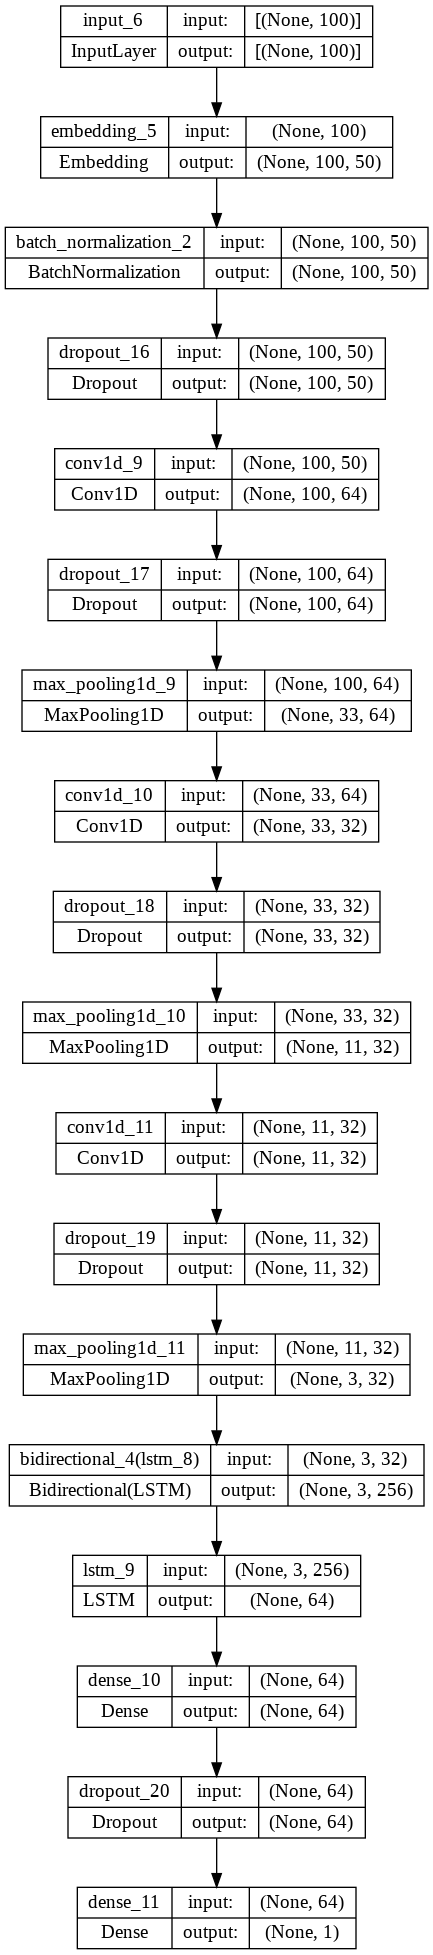

In [147]:
plot_model(model, show_shapes=True)

In [148]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

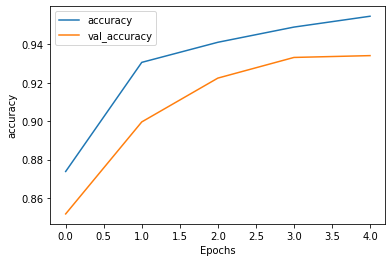

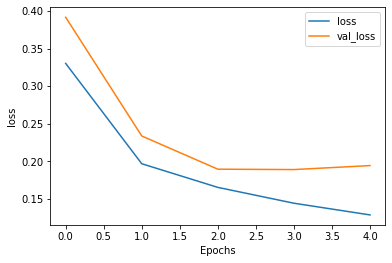

In [149]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [150]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = [(1 if y >= 0.5 else 0) for y in y_pred]
y_pred = np.array(y_pred)

727/727 [==============================] - 4s 4ms/step


In [151]:
y_true

array([1, 1, 0, ..., 1, 1, 1])

In [152]:
y_pred

array([1, 1, 0, ..., 1, 1, 1])

In [153]:
print(classification_report(y_true, y_pred, target_names=['Negative Reviews','Positive Reviews']))

                  precision    recall  f1-score   support

Negative Reviews       0.86      0.70      0.77      3753
Positive Reviews       0.94      0.98      0.96     19492

        accuracy                           0.93     23245
       macro avg       0.90      0.84      0.87     23245
    weighted avg       0.93      0.93      0.93     23245



In [154]:
cm = confusion_matrix(y_test, y_pred)

In [155]:
cm

array([[ 2633,  1120],
       [  412, 19080]])

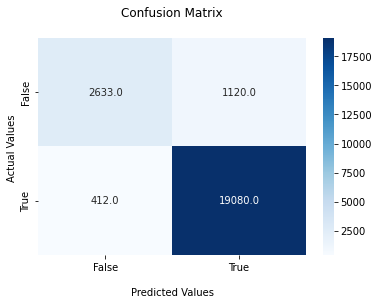

In [156]:
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.1f')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

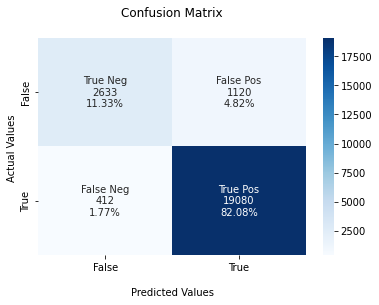

In [157]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [158]:
def prediction(sentence):
  data = tokenizer.texts_to_sequences([sentence])
  data_pad_sequence = pad_sequences(data, maxlen=50)
  perdiction = model.predict(data_pad_sequence)
  print(perdiction[0])
  if perdiction[0][0] > 0.5:
    return "positive"
  else: 
    return "negative" 